In [1]:
import torch
from torch import nn

from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

import torchvision
from torchvision import transforms
from torchvision import datasets

In [2]:
import os
import random

import numpy as np
import matplotlib.pyplot as plt

In [3]:
def train_test_split(dataset, test_split=0.1, random_seed= 42):

    dataset_size = len(dataset) 
    indices = list(range(dataset_size))
    split = int(np.floor(test_split * dataset_size))

    np.random.seed(random_seed)
    np.random.shuffle(indices)
    train_indices, test_indices = indices[split:], indices[:split]

    train_sampler = SubsetRandomSampler(train_indices)
    test_sampler = SubsetRandomSampler(test_indices)

    return train_sampler, test_sampler



In [4]:
images = datasets.ImageFolder("images", transform= transforms.ToTensor())

train_sampler, test_sampler = train_test_split(images, test_split=0.99)

In [5]:
batch_size = 2

loader_train = torch.utils.data.DataLoader(dataset = images, batch_size = batch_size, sampler = train_sampler)
loader_test = torch.utils.data.DataLoader(dataset = images, batch_size = batch_size, sampler = test_sampler)

In [6]:
print(len(loader_test)*batch_size)
print(len(loader_train)*batch_size)

46756
474


torch.float32
torch.Size([2, 3, 336, 336])


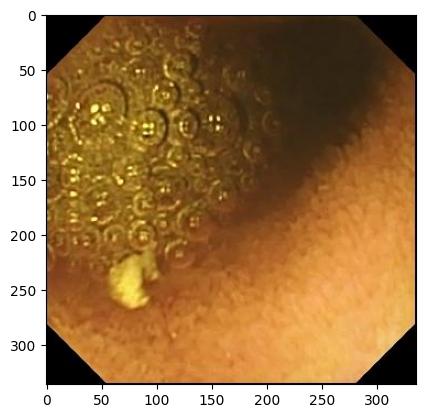

In [7]:
for batch, (img,y) in enumerate(loader_test):

    print(img.dtype)
    print(img.shape)
    plt.imshow(img[0].detach().permute((1,2,0)))

    break


In [8]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()

        self.activ = nn.SELU()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=20, kernel_size=7, padding= 2)
        self.pool1 = nn.MaxPool2d(5,stride = 2)
        self.layer1 = nn.Sequential(self.conv1,self.activ,self.pool1)

        self.conv2 = nn.Conv2d(in_channels=20, out_channels=50, kernel_size=5, padding= 2)
        self.pool2 = nn.MaxPool2d(3,stride = 2)
        self.layer2 = nn.Sequential(self.conv2,self.activ,self.pool2)

        self.conv3 = nn.Conv2d(in_channels=50, out_channels=64, kernel_size=3)
        self.pool3 = nn.MaxPool2d(2,stride = 2)
        self.layer3 = nn.Sequential(self.conv3,self.activ,self.pool3)

        self.encode = nn.Sequential(self.layer1,self.layer2,self.layer3)

 
        self.transA = nn.ConvTranspose2d(in_channels=64, out_channels=50, kernel_size=3, stride= 2)
        self.layerA = nn.Sequential(self.transA,self.activ)
 
        self.transB = nn.ConvTranspose2d(in_channels=50, out_channels=20, kernel_size=5, stride= 2)
        self.layerB = nn.Sequential(self.transB,self.activ)
 
        self.transC = nn.ConvTranspose2d(in_channels=20, out_channels=3, kernel_size=7, stride= 2)
        self.pad = nn.ZeroPad2d((1,0,1,0))
        self.layerC = nn.Sequential(self.transC,self.pad,self.activ)

        self.decode = nn.Sequential(self.layerA,self.layerB,self.layerC)



    

    def forward(self,x):
        encoded = self.encode(x)
        decoded  = self.decode(encoded)
        return decoded




In [9]:
def train(dataloader, model, loss_fn, optimizer, device):

        size = len(dataloader.dataset)
        model.train()

        train_loss = 0
        
        for batch, (img,y) in enumerate(dataloader):
            img = img.to(device)
            pred = model(img)

            loss = loss_fn(pred,img)
            train_loss += loss.item()

            optimizer.zero_grad()
            loss.backward(retain_graph = True)
            optimizer.step()

            if batch % 50 == 0:
                loss, current = loss.item(), batch * len(img)
                print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]") 
        
        train_loss = train_loss/batch+1
        return train_loss
          

In [10]:
def test(dataloader, model, loss_fn, device):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss = 0

    with torch.no_grad():
        for (img,y) in dataloader:
            img = img.to(device)
            pred = model(img)
            test_loss += loss_fn(pred, img).item()
    
    test_loss /= num_batches
    print(f"Test Error: \n Avg loss: {test_loss:>8f} \n")
    return test_loss

In [11]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# device = 'cpu'

network = AutoEncoder().to(device)
network = network.float()


In [12]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(network.parameters(), lr=1e-3)

In [13]:
epoch_nums = []
training_loss = []
test_loss = []

epochs = 15

for epoch in range(epochs):
    print(f"Epoch {epoch+1}\n-------------------------------")

    train_loss = train(loader_train, network, loss_fn, optimizer, device)
    # test_loss = test(loader_test, network, loss_fn, device)

    epoch_nums.append(epoch)
    training_loss.append(train_loss)
    # test_loss.append(test_loss)

    if epoch%10 == 0:
        torch.save(network.state_dict(), "AutoEncoder_Weights.h5")
        print("Saved\n")

print("Done!")

Epoch 1
-------------------------------
loss: 0.217180  [    0/47229]
loss: 0.176950  [  100/47229]
loss: 0.151688  [  200/47229]
loss: 0.135888  [  300/47229]
loss: 0.126583  [  400/47229]
Saved

Epoch 2
-------------------------------
loss: 0.123878  [    0/47229]
loss: 0.116332  [  100/47229]
loss: 0.099533  [  200/47229]
loss: 0.095868  [  300/47229]
loss: 0.087208  [  400/47229]
Epoch 3
-------------------------------
loss: 0.082755  [    0/47229]
loss: 0.070803  [  100/47229]
loss: 0.064322  [  200/47229]
loss: 0.058985  [  300/47229]
loss: 0.058612  [  400/47229]
Epoch 4
-------------------------------
loss: 0.049669  [    0/47229]
loss: 0.047975  [  100/47229]
loss: 0.049270  [  200/47229]
loss: 0.038670  [  300/47229]
loss: 0.040307  [  400/47229]
Epoch 5
-------------------------------
loss: 0.031587  [    0/47229]
loss: 0.039764  [  100/47229]
loss: 0.030807  [  200/47229]
loss: 0.025038  [  300/47229]
loss: 0.029993  [  400/47229]
Epoch 6
-------------------------------
los

In [14]:
torch.save(network.state_dict(), "AutoEncoder_Weights.h5")

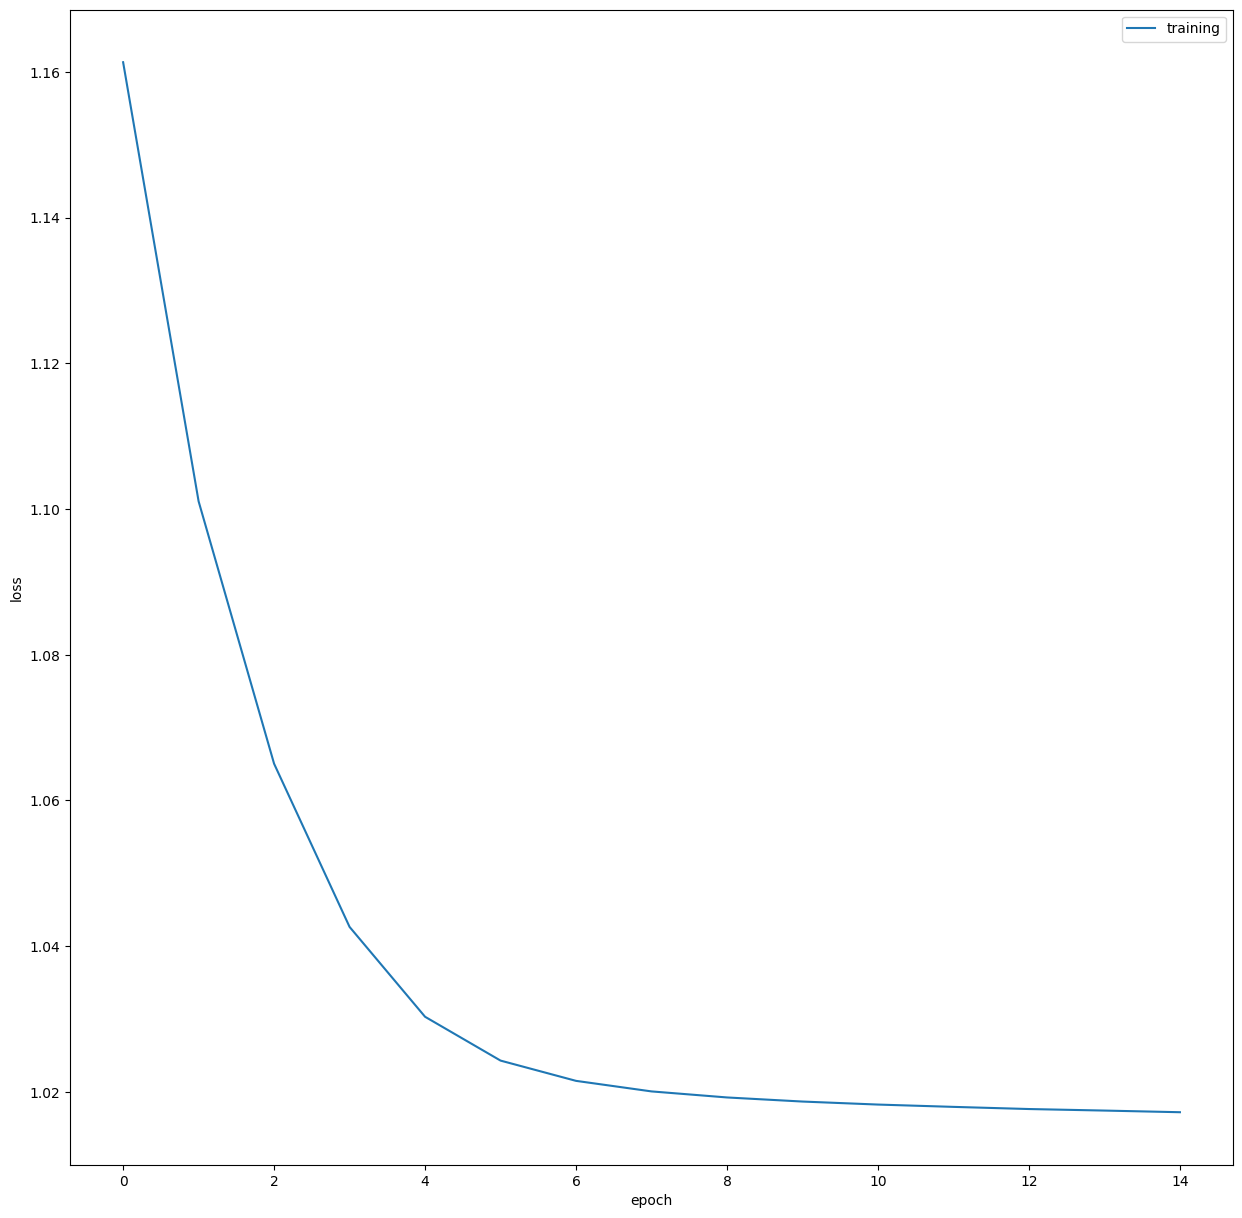

In [15]:
plt.figure(figsize=(15,15))
plt.plot(epoch_nums, training_loss)
# plt.plot(epoch_nums, validation_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()